In [1]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from PIL import Image 
from pathlib import Path
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings 

warnings.filterwarnings('ignore')

In [18]:
train_path = "veg_img_eng"
test_path = "dataset_full_en/test"
validation_path = "dataset_full_en/validation"

In [19]:
num_classes = len(os.listdir(train_path))
num_classes

60

In [20]:
label_list = os.listdir(train_path)
label_list

['Agaricus lemaneiformis',
 'Amaranth',
 'asparagus',
 'Baby Corn',
 'Bamboo shoots',
 'Basil',
 'Beef Tomato',
 'Bell pepper',
 'Big Chinese Cabbage',
 'Big cucumber',
 'Bok Choy',
 'brocoli',
 'cabbage',
 'carrot',
 'celery',
 'chili',
 'Chinese Cabbage',
 'Chinese chives',
 'Chrysanthemum',
 'coriander',
 'corn',
 'cowpea',
 'Cucumber',
 'eggplant',
 'French beans',
 'Garlic',
 'Garlic sprouts',
 'ginger',
 'Green bamboo shoots',
 'Green Broccoli',
 'green onion',
 'Green pepper',
 'Kale',
 'Lettuce',
 'Loofah',
 'Lotus root',
 'Mainland girl',
 'Momordica charantia',
 'Mountain Su',
 'Okra',
 'onion',
 'pea',
 'potato',
 'pumpkin',
 'rape',
 'Red broccoli',
 'Romaine',
 'Shallots',
 'spinach',
 'Sweet Pea',
 'sweet potato',
 'Sweet potato leaves',
 'Taro',
 'Water Lily',
 'Water spinach',
 'WaWa dishes',
 'White radish',
 'Winter melon',
 'Yam',
 'zucchini']

In [21]:
def load_image(data_path, img_size=224):
    X=[]
    y=[]
    label_list = os.listdir(data_path)
    label_num = np.arange(0,len(label_list))
    labels = dict(zip(label_list, label_num))
    
    for label in labels:
        path = Path(data_path)/label
        for img_name in os.listdir(path):
            img_path = Path(path,img_name)
            img = cv2.imread(img_path)
            print(img_path)
            if img is None:
                print(f'Skip {img_path} could not read image')
                continue 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(labels[label])
    return np.array(X), np.array(y)

In [22]:
X_train, y_train = load_image(train_path)
X_train = X_train.astype('float32')/255.0

veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100001.jpeg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100002.jpeg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100003.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100004.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100005.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100006.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100007.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100008.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100009.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100010.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100011.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100012.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100013.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus lemaneiformis100014.jpg
veg_img_eng\Agaricus lemaneiformis\Agaricus le

In [23]:
num_classes = len(os.listdir(train_path))
num_classes

batch_size = 32
img_size = (128, 128)

# Eğitim setini yükleme
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
)
classes = train_ds.class_names
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.shuffle(buffer_size=1000)

train_size = int(0.8 * len(train_ds)) 
test_size = len(train_ds) - train_size

train_dataset = train_ds.take(train_size)
test_dataset = train_ds.skip(train_size)

print(classes)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xdc in position 66: invalid continuation byte

In [8]:
batch_size = 32
img_size = (128, 128)

# 訓練集
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# 驗證集 / 測試集（你可以當作 test_dataset 用）
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# 正規化
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 15066 files belonging to 60 classes.
Using 12053 files for training.
Found 15066 files belonging to 60 classes.
Using 3013 files for validation.


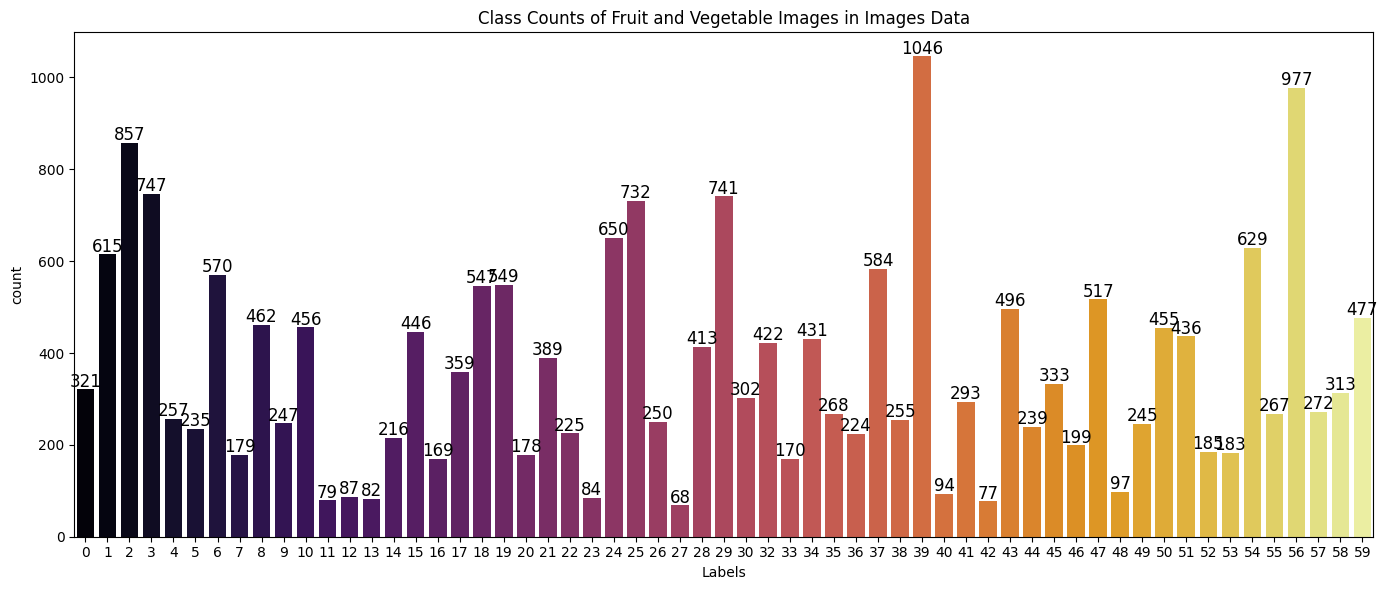

In [16]:
def count_label(y, title):
    plt.figure(figsize=(14, 6))
    ax = sns.countplot(x=y, palette='inferno')
    plt.xlabel('Labels')
    plt.title(f'Class Counts of Fruit and Vegetable Images in {title} Data')
    
    # Her çubuğun üzerine sayıları ekleme
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=12, color='black', 
                    xytext=(0, 2),  # Yüksekliği ayarlamak için
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Örnek kullanım
count_label(y_train, 'Images')

In [ ]:
def plot_image(X,y,path):
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))
    j=0
    for i,ax in enumerate(axes.flat):
        ax.imshow(X[j]) 
        ax.set_title(os.listdir(path)[i], fontsize=10) 
        ax.axis('off') 
        j+=(y == i).sum()
    plt.tight_layout(pad=0.3)  
    plt.show() 

In [ ]:
plot_image(X_train, y_train, train_path)

<a id="5"></a>
## 5-Data Augmentation

In [ ]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [ ]:
train_dataset_aug = train_dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def pred_and_cm(model):
    prediction_probs = model.predict(val_ds)
    predictions = np.argmax(prediction_probs, axis=1)
    cm = confusion_matrix(test_labels, predictions)
    mask = (cm == 0)
    cm_safe = np.where(cm == 0, 1e-6, cm)
    plt.figure(figsize=(12,8))
    ax=sns.heatmap(    
    cm_safe,
    mask=mask, 
    annot=True,
    cmap='viridis',
    norm=LogNorm(vmin=1e-6, vmax=cm_safe.max()),
    xticklabels=label_list,
    yticklabels=label_list,
    annot_kws={'size':12})
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] == 0:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='azure', edgecolor='gray'))
    plt.title('Confusion Matrix')  
    plt.xlabel('Predicted Class')    
    plt.ylabel('True Class')              
                
    plt.show()

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1)) 
    plt.legend()
    plt.title('Accuracy over epochs')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')
    plt.show()

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

<a id="6.3"></a>
### MobileNetV2 Model with no Augmentation

In [2]:
mobile_net_model = keras.applications.MobileNetV2(input_shape=(128,128,3), 
                                                 include_top=False, weights='imagenet')
mobile_net_model.trainable = True 
for layer in mobile_net_model.layers[:-20]:
    layer.trainable = False

model_mnV2 = keras.Sequential([
    mobile_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_mnV2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-7
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_checkpoint.keras",  # 存檔路徑與檔名
    monitor="val_loss",  # 監控指標
    save_best_only=True,  # 只儲存最佳模型
    save_weights_only=False,  # 同時存模型結構與權重
    verbose=1,
)

callbacks = [early_stop, reduce_lr,checkpoint]

history = model_mnV2.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)
plot_history(history)
result_mobile_net_model = pd.DataFrame(history.history)

NameError: name 'num_classes' is not defined

In [ ]:
result_mobile_net_model.tail(5)

In [ ]:
pred_and_cm(model_mnV2)

<a id="6.3"></a>
### MobileNetV2 Model with Augmentation

In [ ]:
mobile_net_model = keras.applications.MobileNetV2(input_shape=(128,128,3), 
                                                 include_top=False, weights='imagenet')
mobile_net_model.trainable = True 
for layer in mobile_net_model.layers[:-20]:
    layer.trainable = False

model_mnV2_aug = keras.Sequential([
    mobile_net_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_mnV2_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_mnV2_aug_checkpoint.keras",  # 存檔路徑與檔名
    monitor="val_loss",  # 監控指標
    save_best_only=True,  # 只儲存最佳模型
    save_weights_only=False,  # 同時存模型結構與權重
    verbose=1,
)

callbacks = [early_stop, reduce_lr,checkpoint]

history = model_mnV2_aug.fit(
    train_dataset_aug,
    epochs=50,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=0
)
plot_history(history)
result_mobile_net_model_aug = pd.DataFrame(history.history)

In [ ]:
result_mobile_net_model_aug.tail(5)

In [ ]:
pred_and_cm(model_mnV2_aug)